## Chinese Word Segmentation (II)--statistical method 

### Unigram is good but it did't consider the context. The probability of a word can rely on previous words.
### Thus, bigram seems better since it takes the previous word into account. Given the a previous word, what is the likelihood of current word. 
## $P(W_{i}|W_{i-1})=\frac{C(W_{i},W_{i-1})}{C(W_{i-1})}$

In [1]:
with open(r'./training_and_testing_data/pku_training.txt',encoding='gbk') as f:# the path may need change
    content=f.readlines()
content="".join(content).strip()
#content=re.sub("。|？|！|\n","<end>",content)
content=content.split("\n")
while '  ' in content:
    content.remove('  ')
while '' in content:
    content.remove('')
for i,sentence in enumerate(content):
    content[i]=content[i].strip()

### Meanwhile, we should also consider a situation when the context becomes new. 
## That is the $P(W_{i}|W_{i-1})$ is very likely to be zero if there is a new context.

## We need interpolation!
## $P^{'}(W_{i}|W_{i-1})=\frac{C(W_{i-1})}{N_{1+}(W_{i-1})+C(W_{i-1})}*P(W_{i}|W_{i-1})+\frac{N_{1+}(W_{i-1})}{N_{1+}(W_{i-1})+C(W_{i-1})}*P(W_{i})$
## That measures what is likely to follow the previous word. Such as Hong Kong, perhaps the only word following "Hong" is "Kong", so the word type($N_{1+}(Hong)$) is very small, the probability will rely mostly on the conditional prob. On the other hand, for word "New", almost every noun can be the next word. So the $N_{1+}(Hong)$ will be pretty high, making the final prob tip a balance between its context and itself.

In [2]:
import re
import math
def biword_count(train_text):
    count={"<begin>":0}#
    for sentence in train_text:
        count["<begin>"]+=1
        #count["<end>"]+=1
        for word in sentence.split("  "):
            if word in count:
                count[word]+=1
            else:
                count[word]=count.get(word,0)+1
    return count
word_dict=biword_count(content)

def pre_word_count(train_text):
    pre_word_count={"<begin>":{}}#given a former word, what is the latter word
    for sentence in train_text:
        words_list=sentence.split("  ")
        for i,word in enumerate(words_list):
            if word not in pre_word_count:
                pre_word_count[word]={}
            if i ==0:
                if word in pre_word_count["<begin>"]:
                    pre_word_count["<begin>"][word]+=1
                else:
                    pre_word_count["<begin>"][word]=pre_word_count["<begin>"].get(word,0)+1
            else:
                if word in pre_word_count[words_list[i-1]]:
                    pre_word_count[words_list[i-1]][word]+=1
                else:
                    pre_word_count[words_list[i-1]][word]=pre_word_count[words_list[i-1]].get(word,0)+1
    return pre_word_count
pre_word_dict=pre_word_count(content)
def check_bigram_prob(pre,cur,pre_word_dict,word_dict):
    if pre in pre_word_dict and cur in pre_word_dict[pre]:
        return pre_word_dict[pre][cur]/word_dict[pre]
    else:
        return 0
def check_unigram_prob(word,word_dict):
    if word in word_dict:
        return (1+word_dict[word])/(1109947+len(word_dict))
    else:
        return 1/(1109947+len(word_dict))
def check_pre_count(pre_word,word_dict):
    if pre_word in word_dict:
        return word_dict[pre_word]+1
    else:
        return 1
def check_pre_type(pre_word,pre_word_dict):
    if pre_word in pre_word_dict:
        return len(pre_word_dict[pre_word].keys())+1
    else:
        return 1
def interpolated_prob(preword,word,pre_word_dict,word_dict):
    if preword not in word_dict:
        return -math.log(check_unigram_prob(word,word_dict))
    elif word in pre_word_dict[preword]:
        return -math.log(word_dict[preword]*check_bigram_prob(preword,word,pre_word_dict,word_dict)/(word_dict[preword]+check_pre_type(preword,pre_word_dict)*check_unigram_prob(word,word_dict)/(word_dict[preword]+check_pre_type(preword,pre_word_dict))))
    else:
        return -math.log(check_pre_type(preword,pre_word_dict)*check_unigram_prob(word,word_dict)/(word_dict[preword]+check_pre_type(preword,pre_word_dict)))
#interpolated_prob("长江","大桥",pre_word_dict,word_dict)

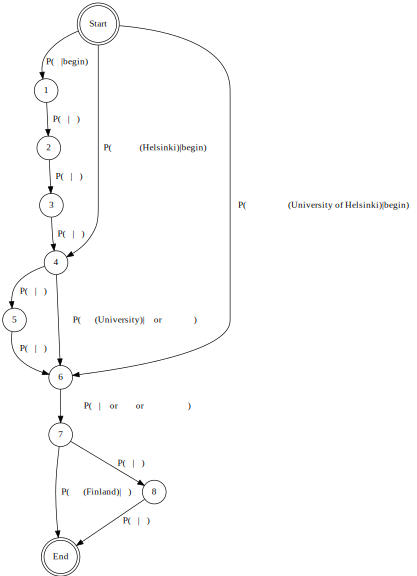

In [3]:
import graphviz
f = graphviz.Digraph()
f.attr(size='8,8')
f.attr('node', shape='doublecircle')
f.node('End')
f.node('Start')
f.attr('node', shape='circle')
f.edge('Start', '1',label='P(赫|begin)')
f.edge('1', '2', label='P(尔|赫)')
f.edge('2', '3',label='P(辛|尔)')
f.edge('3', '4',label='P(基|辛)')
f.edge('Start', '4',label='P(赫尔辛基(Helsinki)|begin)')

f.edge('4', '5',label='P(大|基)')
f.edge('5', '6',label='P(学|大)')
f.edge('4', '6',label='P(大学(University)|基 or 赫尔辛基 )')
f.edge('Start', '6',label='P(赫尔辛基大学(University of Helsinki)|begin)')
f.edge('6', '7',label='P(在|学 or 大学 or 赫尔辛基大学)')
f.edge('7', '8',label='P(芬|在)')
f.edge('8', 'End',label='P(兰|芬)')
f.edge('7', 'End',label='P(芬兰(Finland)|在)')
f

In [3]:
def split_sentence(sentence,pre_word_dict,word_dict):
    cutpoint={}
    l=len(sentence)
    #'''
    #add regular expression
    time_pattern="([0-9零一二三四五六七八九十o○.]{2,}[年月日点时分秒%]*)"
    time_list=re.findall("([0-9零一二三四五六七八九十o○.]{2,}[年月日点时分秒%]*)",sentence)
    sentence=re.sub(time_pattern,"T",sentence)
    #add regular expression
    #'''
    for i in range(l):#generating directed acyclic graph
        cutpoint[i]=[]
        for j in range(i,l):
            if sentence[i:j+1] in word_dict:
                cutpoint[i].append(j)
        if cutpoint[i]==[]:
            cutpoint[i].append(i)
    #print(cutpoint)
    prenode=dict.fromkeys(range(l), 0) # set node 0 as default
    node_cost=[]
    #best_pre=[] 
    for i in cutpoint:
        if i ==0:
            for j in cutpoint[i]:
                node_cost.append([-1,-1,0,j,interpolated_prob("<begin>",sentence[i:j+1],pre_word_dict,word_dict)])
                #best_index,best_cost=(min([(j,interpolated_prob("<begin>",sentence[i:j+1],pre_word_dict,word_dict)) for j in cutpoint[i]]))
                prenode[(i,j)]=(-1,-1)
                
        else:
            if i-1 in [n[3] for n in node_cost]:# only if previous index is an ending index of a word
                for j in cutpoint[i]:
                    node_cost.append(min([(n[2],n[3],i,j,
                                          n[4]+interpolated_prob(sentence[n[2]:n[3]+1],sentence[i:j+1],pre_word_dict,word_dict))
                                          for n in node_cost if n[3] == i-1]
                                         ,key=lambda x:x[4]))
                    # node_cost will append a tuple like (i,j,m,n,5.13) where i to j is slice of previous word, m & n are staring and ending index of current word. 
                    #The last is current weight, and min([],key = the current weight) 
                #best_index,best_cost=(min([(j,interpolated_prob(sentence[prenode[i-1]:i],sentence[i:j+1],pre_word_dict,word_dict)) for j in cutpoint[i]]))
                    prenode[(i,j)]=(node_cost[-1][0],node_cost[-1][1])
    #print(node_cost)
    back_index=l-1
    split=[];result=[]
    start,end,low_cost=min([(n[2],n[3],n[4]) for n in node_cost if n[3] == back_index],key=lambda x:x[2])
    split.append((start,end))
    while back_index>0:
        back_index=prenode[split[-1]][0]
        split.append(prenode[split[-1]])
    for nodes in split[::-1]:
        result.append(sentence[nodes[0]:nodes[1]+1])
    #'''
    #add regular expression    
    result='  '.join(result)
    for i in range(len(time_list)):
        result=result.replace("T",time_list[0],1)
        time_list.pop(0)
    #add regular expression
    #'''
    result=''.join(result)# if regular expression function is turned off, reuslt should be '  '.join(result)
    return result
#split_sentence("办案人员还是，",pre_word_dict,word_dict)

In [4]:
split_sentence("赫尔辛基大学在芬兰",pre_word_dict,word_dict)# The university of Helsinki is in Finland.

'赫尔辛基  大学  在  芬兰'

In [5]:
with open(r'./training_and_testing_data/pku_test.txt',encoding='gbk') as f:# the path may need change
    test=f.readlines()
for i,s in enumerate(test):
    test[i]=split_sentence(s,pre_word_dict,word_dict)

In [7]:
with open('pku_test_segmentation_bi_re.txt',"a") as f:
    f.writelines(test)